In [1]:
import numpy as np 
# import cvxpy
import matplotlib.pyplot as plt

import nengo 
from nengo.dists import Choice 
from nengo.utils.ensemble import tuning_curves
from nengo.utils.matplotlib import rasterplot
from nengo.neurons import Direct

# import tensorflow as tf
import gym
import pickle
# import cvxpy 

import pdb

In [2]:
dnn_weights = pickle.load(open('./Weights/DNN_weights.p', 'rb'))
dnn_layers = len(dnn_weights)
dnn_activations = pickle.load(open('./Weights/activations.p', 'rb'))
h = 64

INPUT_DIMS = 4
OUTPUT_DIMS = 2

def softmax(x):
        e_x = np.exp(x - np.max(x))
        return e_x / e_x.sum()

In [3]:
N = 10000
ANN = nengo.Network()
ANN_layers = {}
with ANN: 
    for i, weight in enumerate(dnn_weights):
        dim = weight.shape[0]
        size = weight.shape[1]
        ANN_layers[i] = nengo.Ensemble(size, 
                            dimensions=dim,
                            encoders=weight.T,
                            neuron_type=nengo.RectifiedLinear(),
                            max_rates = np.ones([size,]),
                            intercepts = np.zeros([size,])
                            )

    input_node = nengo.Node(lambda t: observation, 
                           size_out=dnn_weights[0].shape[0]
                           )

    nengo.Connection(input_node, ANN_layers[0],
                     synapse = nengo.synapses.LinearFilter([1],[1, 0], analog=False)
                    )
    
    nengo.Connection(ANN_layers[0].neurons, ANN_layers[1],
                     synapse = nengo.synapses.LinearFilter([1],[1, 0], analog=False)
                    )
    
    nengo.Connection(ANN_layers[1].neurons, ANN_layers[2],
                    synapse = 0
                    )

    inp = nengo.Probe(input_node, 
                      synapse = 0)
    l0 = nengo.Probe(ANN_layers[0].neurons, 
                      synapse = 0)
    l1 = nengo.Probe(ANN_layers[1].neurons, 
                       synapse = nengo.synapses.LinearFilter([1],[1, 0], analog=False))
    l2 = nengo.Probe(ANN_layers[2].neurons, 'input', 
                      synapse = 0)

ann_activations = {}
evals = np.random.normal(loc=0.0, scale=1.0, size=[N,dnn_weights[0].shape[0]])
for i in range(3):
    with nengo.Simulator(ANN) as sim: 
        _, ann_activations[i] = tuning_curves(ANN_layers[i], sim, inputs=evals) 
    evals = ann_activations[i]


Building finished in 0:00:01.                                                                                           
Building finished in 0:00:01.                                                                                           
Building finished in 0:00:01.                                                                                           


In [4]:
env = gym.make('CartPole-v0')

[2017-05-28 12:47:43,449] Making new env: CartPole-v0


In [5]:
observation = env.reset()
done = False
score = 0.0
T = 0.1
while not done: 
    with nengo.Simulator(ANN) as sim: 
        sim.run(T, progress_bar=False)
    out_1 = sim.data[l2][:,0].mean()
    out_2 = sim.data[l2][:,1].mean()
    aprob = softmax([out_1,out_2])
    action = np.random.choice(OUTPUT_DIMS, p=aprob)
    observation, reward, done, info = env.step(action)
    score += reward
    
print(score)

Building finished in 0:00:01.                                                                                           
Building finished in 0:00:01.                                                                                           
Building finished in 0:00:01.                                                                                           
Building finished in 0:00:01.                                                                                           
Building finished in 0:00:01.                                                                                           
Building finished in 0:00:01.                                                                                           
Building finished in 0:00:01.                                                                                           
Building finished in 0:00:01.                                                                                           
Building finished in 0:00:01.   

In [272]:
def snn_translalte(model, layers, weights, sizes, rels=None, round=None, samples=10000, radius=1.0, neuron_type='LIF'):
    ''' Function translates a model of a fully-connected analog neural network (ANN) to an 
    equivalent spiking neural network (SNN). SNN takes input from global variable 'x' by default 
    model: Nengo Network
        Model of analog neural network (ANN) specified as nengo model with non-spiking neurons 
        (will expand to TensorFlow later)
    layers: List
        List containing the layers (ensembles) of the ANN model 
    weights: List
        List of ANN layer weights of dimensions (IN, OUT). This should be eliminated in future
        versions 
    sizes: List (layers)
        List containing the number of neurons for each layer of the SNN. Should be the same 
        length as the number of layers in the ANN model 
    rels: List (layers), Default=None
        List containing the number of singular value basis functions (U-basis vectors) to be 
        used for each translation. If None, then the basis will not be truncated 
    round: Int or None, Default=None
        Number of decimals the basis vectors should be rounded to after SVD. If None, then 
        no rounding will occur
    samples: Int, Default=10000
        Number of samples to take for decoder regression
    radius: Int or Float, default=1.0
        Raius of samples taken for regression 
    neuron_type: string
        Nengo neuron model to employ for SNN. Currently only Leaky-Integrate-and-Fire is 
        supported (LIF)
    '''
    input_dim = weights[0].shape[0]
    evals = np.random.uniform(-radius, radius, size=[samples,input_dim])
    A = evals[:]
    
    ann_activations = {}
    ann_activations[0] = A
    for i in range(len(sizes)):
        with nengo.Simulator(model) as sim: 
            _, ann_activations[i+1] = tuning_curves(layers[i], sim, inputs=A) 
        A = ann_activations[i+1]
    encoders = {}
    for i in range(len(sizes)):
        size = sizes[i]
        F = ann_activations[i].dot(weights[i])
        U, s, V = np.linalg.svd(F,full_matrices=False)
        V_ = V[:size, :size]
        S = np.diag(s)
        S_ = S[:,:size]
        if rels is not None: 
            rel = rels[i]
            U_ = U[:,:rel]
            S_ = S_[:rel, :]
        else: 
            U_ = U
        F_ = (U_.dot(S_)).dot(V_) #Truncated target function 
        
        if i == 0:
            a = evals
        else:
            test_model = nengo.Network()
            with test_model:
                dim = size
                ens = nengo.Ensemble(size, 
                                    dimensions=dim,
                                    encoders=np.identity(size),
                                    neuron_type=nengo.LIF(),
                                    gain = np.ones([size,]),
                                    bias = np.zeros([size,]),
#                                     normalize_encoders=False
                                    )
            with nengo.Simulator(test_model) as sim: 
                _, a = tuning_curves(ens, sim, inputs=evals)
        u, s, v = np.linalg.svd(a, full_matrices=False)
        s_ = np.diag(s)
        if rels is not None: 
            rel = rels[i]
            u_ = u[:,:rel]
            s_ = s_[:rel, :]
        else: 
            u_ = u
        a_ = (u_.dot(s_)).dot(v)
        #This solver may be different for constrained solutions 
        enc = np.linalg.pinv(a_).dot(F_)
        encoders[i] = enc
        evals = a.dot(enc)
    
    #Build the Network 
    prior_size = input_dim
    snn = nengo.Network()
    snn_layers = {}
    with snn: 
        inp = nengo.Node(lambda t: snn_input)
        for i in range(len(sizes)):
            size = sizes[i]
            snn_layers[i] = nengo.Ensemble(size, 
                                dimensions=prior_size,
#                                 encoders=encoders[i].T,
                                neuron_type=nengo.LIF(),
                                gain = np.ones([size,]),
                                bias = np.zeros([size,]),
#                                 normalize_encoders=False
                                )
            prior_size = size
            if i == 0:
                nengo.Connection(inp, snn_layers[i].neurons,
                                 transform=encoders[i].T,
                                synapse = 0.0005)
            else: 
                nengo.Connection(snn_layers[i-1].neurons, snn_layers[i].neurons,
                                transform=encoders[i].T)
                
        in_probe = nengo.Probe(inp, synapse=0.01, label='in_probe')
        out_probe = nengo.Probe(snn_layers[len(sizes)-1].neurons, 'input', 
                          synapse=0.005, label='out_probe')
    return snn, inp, in_probe, out_probe, snn_layers
            
        

In [277]:
SNN, inp, in_probe, out_probe, SNN_layers = snn_translalte(ANN, ANN_layers, dnn_weights, [64, 64, 2], rels=None, round=None, samples=10000, radius=1.0, neuron_type='LIF')


Building finished in 0:00:01.                                                                                           
Building finished in 0:00:01.                                                                                           
Building finished in 0:00:01.                                                                                           
Building finished in 0:00:01.                                                                                           
Building finished in 0:00:01.                                                                                           


Building finished in 0:00:01.                                                                                           
Simulating finished in 0:00:01.                                                                                         
Building finished in 0:00:01.                                                                                           
Simulating finished in 0:00:01.                                                                                         


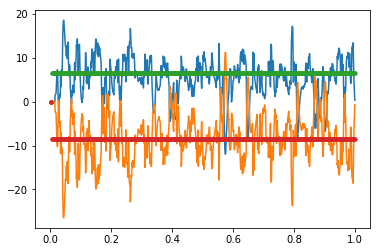

In [278]:
snn_input = np.array([1.0,1.0,-1.0,-1.0])
observation = snn_input
T_INT = 1.0
with nengo.Simulator(SNN) as sim:
    sim.run(T_INT)
    
with nengo.Simulator(ANN) as sim2:
    sim2.run(T_INT)
    
# plt.figure()
# plt.plot(sim.trange(), sim.data[in_probe])

plt.figure()
plt.plot(sim.trange(), sim.data[out_probe])
plt.plot(sim2.trange(), sim2.data[l2],'.')
plt.show()


In [6]:
P = 20
snn_weights = []
evals = np.random.normal(loc=0.0, scale=1.0, size=[N,dnn_weights[0].shape[0]]).dot(dnn_weights[0])
# pdb.set_trace()
snn_weights.append(dnn_weights[0])
enc = dnn_weights[0].T
for i, activation in ann_activations.items():
    if i < 2:
        test_model = nengo.Network()
        with test_model:
#             pdb.set_trace()
            dim = activation.shape[1]
            size = activation.shape[1]
            ens = nengo.Ensemble(size, 
                                dimensions=dim,
                                encoders=np.identity(size),
                                neuron_type=nengo.LIF(),
                                gain = np.ones([size,]),
                                bias = np.zeros([size,])
                                )

        with nengo.Simulator(test_model) as sim: 
            _, A = tuning_curves(ens, sim, inputs=evals)
        u, s, v = np.linalg.svd(A)
        n = s.shape[0]
        sig = np.zeros(A.shape)
        sig[:n, :n] = np.diag(s)
#         sig_ = sig[:, :size]
#         v_ = v[:size, :size]
#         enc = u_.dot(sig_).dot(v_)
        f = activation.dot(dnn_weights[i+1])
#         pdb.set_trace()
        snn_weights.append(np.linalg.pinv(A).dot(f))
#         pdb.set_trace()
        evals = f[:]
    else: 
        pass

Building finished in 0:00:01.                                                                                           
Building finished in 0:00:01.                                                                                           


In [7]:
SNN = nengo.Network()
SNN_layers = {}
with SNN: 
    for i, weight in enumerate(snn_weights):
        dim = weight.shape[0]
        size = weight.shape[1]
        SNN_layers[i] = nengo.Ensemble(size, 
                            dimensions=dim,
                            encoders=weight.T,
                            neuron_type=nengo.LIF(),
                            max_rates = np.ones([size,]),
                            intercepts = np.zeros([size,])
                            )

    input_node_s = nengo.Node(lambda t: observation, 
                           size_out=dnn_weights[0].shape[0]
                           )

    nengo.Connection(input_node_s, SNN_layers[0],
                     synapse = 0.01
                    )
    
    nengo.Connection(SNN_layers[0].neurons, SNN_layers[1],
                     synapse = 0.01
                    )
    
    nengo.Connection(SNN_layers[1].neurons, SNN_layers[2],
                    synapse = 0.01
                    )

    inp_s = nengo.Probe(input_node_s, 
                      synapse = 0.01)
    l0s = nengo.Probe(SNN_layers[0].neurons, 
                      synapse = 0.01)
    l1s = nengo.Probe(SNN_layers[1].neurons, 
                       synapse = 0.01)
    l2s = nengo.Probe(SNN_layers[2].neurons, 'input', 
                      0.01)


In [29]:
observation = env.reset()
done = False
score = 0.0
T = 0.5
Loss = []
while not done: 
    with nengo.Simulator(ANN) as sim_ann: 
        sim_ann.run(T, progress_bar=False)
    ann_out_1 = sim_ann.data[l2][:,0].mean()
    ann_out_2 = sim_ann.data[l2][:,1].mean()
    ann_aprob = softmax([ann_out_1,ann_out_2])
    
    with nengo.Simulator(SNN) as sim_snn: 
        sim_snn.run(T, progress_bar=False)
    snn_out = np.mean(sim_snn.data[l1s][100:,:], axis=0).dot(snn_weights[2])
    snn_out_1 = snn_out[0]
    snn_out_2 = snn_out[1]
#     snn_out_1 = sim_snn.data[l2s][100:,0].mean()
#     snn_out_2 = sim_snn.data[l2s][100:,1].mean()
    snn_aprob = softmax([snn_out_1,snn_out_2])
    print(snn_out)
#     pdb.set_trace()
    action = np.random.choice(OUTPUT_DIMS, p=snn_aprob)
    observation, reward, done, info = env.step(action)
    score += reward
    loss = snn_out_1 - ann_out_1
    Loss.append(loss)

Loss_ = np.array(Loss)
RMSE = np.sqrt(np.mean(Loss_**2))
print('Score: %r' % score)
print('RMSE: %r' % RMSE)

Building finished in 0:00:01.                                                                                           
Building finished in 0:00:01.                                                                                           
[ 0.  0.]
Building finished in 0:00:01.                                                                                           
Building finished in 0:00:01.                                                                                           
[ 0.  0.]
Building finished in 0:00:01.                                                                                           
Building finished in 0:00:01.                                                                                           
[ 0.  0.]
Building finished in 0:00:01.                                                                                           
Building finished in 0:00:01.                                                                                           
[ 

KeyboardInterrupt: 